In [11]:
!pip3 install polars pandana pandas pyrosm matplotlib numpy

In [1]:
import polars as pl
import os
import pandas as pd
import geopandas as gpd
from pyrosm import OSM, get_data
import numpy as np
import matplotlib.pyplot as plt
import pandana
from shapely.geometry import LineString

# Compute pairs of consecutive stops in the time table

## Load data

In [2]:
# GTFS data (used for timetable)
STATIC_GTFS_URL="https://eu.ftp.opendatasoft.com/stif/GTFS/IDFM-gtfs.zip"
STATIC_GTFS_FILE_PATH="raw_data/gtfs.zip"
STATIC_GTFS_PATH="raw_data/gtfs"

In [33]:
stop_times_path = os.path.join(STATIC_GTFS_PATH, 'stop_times.txt')
stop_times_cols = ['trip_id','stop_id','stop_sequence']
stop_times_dtype = {'trip_id': pl.String,
                    'stop_id': pl.String,
                    'stop_sequence': pl.Int16}
stop_times = pl.scan_csv(stop_times_path, schema_overrides=stop_times_dtype).select(stop_times_cols)

In [35]:
stops_path = os.path.join(STATIC_GTFS_PATH, 'stops.txt')
stops_dtype = {'stop_id': pl.String,
               'stop_name': pl.String,
               'stop_lat': pl.Float64,
               'stop_lon': pl.Float64,
               }
stops = pl.scan_csv(stops_path, schema_overrides=stops_dtype).select(list(stops_dtype.keys()))

# Compute graph of Ile-de-France driving network from OSM data

In [42]:
# Download data for Ile de France region from OpenStreetMap
idf_osm = OSM(get_data("Ile de France"))

In [43]:
# Parse street networks from OSM data
nodes, edges = idf_osm.get_network(nodes=True, network_type="driving")

In [24]:
# Export OSM network to routable graph
G = idf_osm.to_graph(nodes, edges, graph_type="pandana")

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 2172010
Setting CH edge vector of size 3874586
Range graph removed 3100764 edges of 7749172
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [25]:
# Save graph data
G.save_hdf5('data/osm_driving_network.h5')

## Load computed graph

In [5]:
G = pandana.Network.from_hdf5('data/osm_driving_network.h5')

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 2172010
Setting CH edge vector of size 3874586
Range graph removed 3100764 edges of 7749172
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


# Compute path between consecutive stops

## Get node in graph of each stop

In [36]:
stops_x_y = stops.select(['stop_lon', 'stop_lat']).collect().to_pandas()

In [37]:
# Get nearest graph node of all stops for selected bus line
node_ids = G.get_node_ids(stops_x_y.stop_lon.values, stops_x_y.stop_lat.values)

In [38]:
# Enrich stops dataframe
stops = stops.with_columns(pl.Series(name="node_id", values=node_ids))

## Enrich time table with stop data

In [39]:
stop_times = stop_times.join(stops, on='stop_id')

In [40]:
stop_times = stop_times.sort(['trip_id', 'stop_sequence'])

## Get consecutive stops pairs

In [41]:
stop_pairs = (
  pl.concat([stop_times.rename(lambda col: "orig_" + col),
             stop_times.rename(lambda col: "dest_" + col).shift(-1)],
             how='horizontal'
            )
  .filter(pl.col('orig_trip_id') == pl.col('dest_trip_id'))
  .filter(pl.col('orig_stop_sequence') < pl.col('dest_stop_sequence'))
  .filter(pl.col('orig_stop_id') != pl.col('dest_stop_id'))
  .drop(['orig_trip_id', 'dest_trip_id', 'orig_stop_sequence', 'dest_stop_sequence']).unique()
)
stop_pairs = stop_pairs.collect()
stop_pairs

orig_stop_id,orig_stop_name,orig_stop_lat,orig_stop_lon,orig_node_id,dest_stop_id,dest_stop_name,dest_stop_lat,dest_stop_lon,dest_node_id
str,str,f64,f64,i64,str,str,f64,f64,i64
"""IDFM:4865""","""Le Gradient""",48.764005,2.086507,7838417158,"""IDFM:4566""","""Technocentre - L'Étang""",48.757899,2.087825,10139511196
"""IDFM:27451""","""Chastenet de Géry""",48.805797,2.358141,9655030692,"""IDFM:464058""","""Les Coquettes""",48.804297,2.358554,9655030693
"""IDFM:463591""","""Ramponeau""",48.870514,2.378229,1789061726,"""IDFM:463626""","""Couronnes""",48.868593,2.380692,1789061771
"""IDFM:39814""","""Pont Neuf - Quai du Louvre""",48.858212,2.34313,2880573972,"""IDFM:39780""","""Châtelet - Quai de Gesvres""",48.856934,2.347848,12031269002
"""IDFM:13962""","""Péguy""",48.926359,2.050164,10827452734,"""IDFM:34883""","""Commissariat""",48.927207,2.043685,473690881
…,…,…,…,…,…,…,…,…,…
"""IDFM:20796""","""Circuit Automobile""",48.757456,1.983912,4188140583,"""IDFM:20775""","""Fermi""",48.762009,1.98102,10575617690
"""IDFM:3070""","""Sous-Préfecture""",48.436396,2.16458,534957188,"""IDFM:3082""","""Z.I. Coquerive""",48.433424,2.173077,455621130
"""IDFM:426435""","""Ecole Jean Jaurès""",48.979151,2.387531,8681364874,"""IDFM:25609""","""Garges - Sarcelles RER""",48.977026,2.390466,6025223416


## Get paths

In [42]:
# Compute shortest path between consecutive stops
orig = stop_pairs['orig_node_id']
dest = stop_pairs['dest_node_id']
shortest = G.shortest_paths(orig, dest)

In [43]:
# Enrich stop_pairs with shortest path
stop_pairs = stop_pairs.with_columns(pl.Series(name="shortest_path", values=shortest))

### Convert paths to lists of position

In [44]:
shortest_pos = [G.nodes_df.loc[s.tolist()] for s in shortest]

In [45]:
# Enrich stop_pairs with shortest path positions
stop_pairs = stop_pairs.with_columns(pl.Series(name='shortest_path_pos', values=shortest_pos))
stop_pairs = stop_pairs.with_columns(pl.col('shortest_path_pos').map_elements(lambda x: LineString(x) if len(x) > 1 else None, return_dtype=pl.Object).alias("geometry"))

In [46]:
stop_pairs.head(3)

orig_stop_id,orig_stop_name,orig_stop_lat,orig_stop_lon,orig_node_id,dest_stop_id,dest_stop_name,dest_stop_lat,dest_stop_lon,dest_node_id,shortest_path,shortest_path_pos,geometry
str,str,f64,f64,i64,str,str,f64,f64,i64,list[i64],object,object
"""IDFM:4865""","""Le Gradient""",48.764005,2.086507,7838417158,"""IDFM:4566""","""Technocentre - L'Étang""",48.757899,2.087825,10139511196,"[7838417158, 265046080, … 10139511196]",x y 7838417158 2.086427 48.763931 265046080 2.084471 48.765564 7787057472 2.084442 48.765598 265046081 2.084371 48.765739 265046042 2.084358 48.765839 ... ... ... 1332668337 2.087622 48.757908 1332668394 2.087712 48.757896 10139511194 2.087751 48.757885 10139511195 2.087779 48.757874 10139511196 2.087805 48.757862 [69 rows x 2 columns],"LINESTRING (2.0864274501800537 48.76393127441406, 2.084470748901367 48.76556396484375, 2.084442138671875 48.76559829711914, 2.0843710899353027 48.76573944091797, 2.084357500076294 48.765838623046875, 2.0844056606292725 48.765865325927734, 2.0844430923461914 48.76589584350586, 2.084468364715576 48.765933990478516, 2.084479808807373 48.765987396240234, 2.0844662189483643 48.76604080200195, 2.084428548812866 48.766090393066406, 2.0843706130981445 48.76612854003906, 2.0842974185943604 48.766151428222656, 2.084216594696045 48.76616287231445, 2.08412504196167 48.766151428222656, 2.0840442180633545 48.7661247253418, 2.0839836597442627 48.766075134277344, 2.0839664936065674 48.766056060791016, 2.083954334259033 48.766029357910156, 2.0839462280273438 48.76597595214844, 2.0839638710021973 48.76592254638672, 2.084005117416382 48.76587677001953, 2.0840492248535156 48.765846252441406, 2.084101915359497 48.76582717895508, 2.084160089492798 48.76581573486328, 2.084221601486206 48.765811920166016, 2.084235906600952 48.76569366455078, 2.084298849105835 48.765541076660156, 2.084843397140503 48.76512145996094, 2.0855767726898193 48.76449966430664, 2.0858519077301025 48.76426696777344, 2.0860238075256348 48.764122009277344, 2.0864903926849365 48.76373291015625, 2.0867106914520264 48.763545989990234, 2.086956739425659 48.763343811035156, 2.087024211883545 48.76328659057617, 2.0883615016937256 48.76215744018555, 2.0883264541625977 48.762115478515625, 2.0883100032806396 48.76206970214844, 2.088313102722168 48.762020111083984, 2.0883359909057617 48.7619743347168, 2.0883679389953613 48.761940002441406, 2.0884106159210205 48.76191329956055, 2.088489532470703 48.76188278198242, 2.088578939437866 48.761871337890625, 2.0886685848236084 48.76188278198242, 2.0887832641601562 48.761817932128906, 2.0889201164245605 48.761695861816406, 2.0891001224517822 48.76154708862305, 2.0891764163970947 48.7614631652832, 2.0892927646636963 48.76128005981445, 2.0893328189849854 48.761146545410156, 2.089332103729248 48.760990142822266, 2.0892932415008545 48.76084899902344, 2.0890235900878906 48.760284423828125, 2.0889153480529785 48.760032653808594, 2.0888586044311523 48.759910583496094, 2.088716983795166 48.75960159301758, 2.0884642601013184 48.75905227661133, 2.0880467891693115 48.758121490478516, 2.087852716445923 48.75801086425781, 2.087794542312622 48.75798416137695, 2.0877468585968018 48.75796127319336, 2.0876989364624023 48.75794219970703, 2.0876219272613525 48.75790786743164, 2.087712049484253 48.757896423339844, 2.0877513885498047 48.75788497924805, 2.0877792835235596 48.75787353515625, 2.0878052711486816 48.75786209106445)"
"""IDFM:27451""","""Chastenet de Géry""",48.805797,2.358141,9655030692,"""IDFM:464058""","""Les Coquettes""",48.804297,2.358554,9655030693,"[9655030692, 4954866688, … 9655030693]",x y 9655030692 2.358221 48.805790 4954866688 2.358266 48.805729 5732693891 2.358303 48.805660 9758772467 2.358359 48.805553 771779566 2.358403 48.805447 318537432 2.358411 48.805420 771779493 2.358432 48.805355 771779395 2.358455 48.805286 9758772468 2.358475 48.805206 318537433 2.358503 48.805073 301374743 2.358542 48.804863 9397113903 2.358551 48.804817 9655030693 2.358645 48.804291,"LINESTRING (2.3582212924957275 48.

## Example

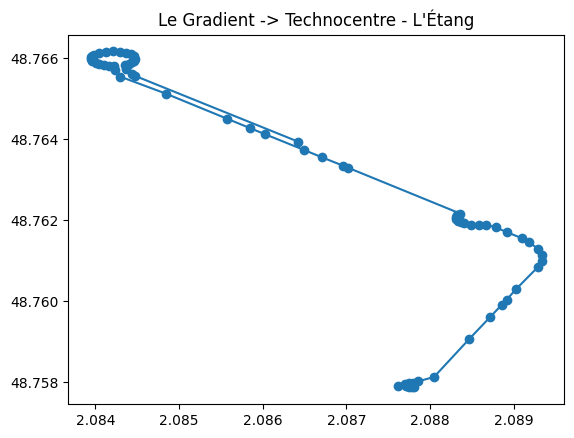

In [77]:
# Plot route
example = stop_pairs.head(1)
path_node_pos = example.select('shortest_path_pos').item()
path = example.select('geometry').item()
title = example.select('orig_stop_name').item() + " -> " + example.select('dest_stop_name').item()

plt.scatter(path_node_pos.x, path_node_pos.y)
plt.plot(*path.xy)
plt.title(title)
plt.show()

In [48]:
shortest[0]

array([ 7838417158,   265046080,  7787057472,   265046081,   265046042,
        1311895975,  7787057466,   265046043,   265046044,  1311896143,
         265046045,  1311895998,   265046046,   652432680,   265046047,
        7787057467,   265046048,  7787057468,  1311895994,   338398928,
        1311895996,   265046040,  1311895974,  1314566289,  7787057465,
         265046041,   265046054,   265046055,  1315544268,  1312824175,
        1312868555,   652423869,  1316081239,  1316081268,  7838417151,
        1315544358,   265046067,  1311895986,  1311896008, 10139389215,
         265046068,  1311896068,  1316575132,   265046069,  1311896019,
         265046070,   265046351,   265046352,  5349705231,   265046353,
         265046355,   265046356,  5349705230,   265046357,  1316575105,
         652423891,  1332668388,  1332668390,   652423890,  1332668356,
        1332668364, 10139511197, 10139511199, 10139511198,  1332668337,
        1332668394, 10139511194, 10139511195, 10139511196])

In [49]:
G.nodes_df[G.nodes_df.index.isin(shortest[0])]

,x,y
265046048,2.083984,48.766075
265046040,2.084005,48.765877
1311895974,2.084049,48.765846
1314566289,2.084102,48.765827
7787057465,2.084160,48.765816
...,...,...
1311896008,2.088310,48.762070
10139389215,2.088313,48.762020
1311896068,2.088368,48.761940
265046069,2.088490,48.761883


In [50]:
shortest_pos[0]

,x,y
7838417158,2.086427,48.763931
265046080,2.084471,48.765564
7787057472,2.084442,48.765598
265046081,2.084371,48.765739
265046042,2.084358,48.765839
...,...,...
1332668337,2.087622,48.757908
1332668394,2.087712,48.757896
10139511194,2.087751,48.757885
10139511195,2.087779,48.757874


### Save data

In [51]:
# Convert to GeoPandas and save to parquet file
(
    gpd.GeoDataFrame(
        stop_pairs.to_pandas()
    )
    .drop(columns=['shortest_path', 'shortest_path_pos',
                   'orig_node_id', 'dest_node_id',
                   'orig_stop_name', 'dest_stop_name'])
    .to_parquet('data/consecutive_stops_path.parquet')
)